In [1]:
#Throughout this document, things that can be changed by the user to investigate different 
#parts of the map are marked with #FINDME

# Import functions
import numpy as np
import matplotlib.pyplot as p
%matplotlib inline

import eigencurves
import eigenmaps
import kmeans
import bin_eigenspectra
import os
import pdb
import spiderman as sp

import gen_lightcurves_new_starry as gen_lightcurves
import healpy as hp

import colorcet as cc
from colormap2d import generate_map2d
from matplotlib import colorbar, cm
from matplotlib.colors import BoundaryNorm, Normalize
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
p.rc('text', usetex=True)
p.rc('font', family='serif')

#import run_higher_sph_harm
from eigensource import plot_utils

import starry
starry.config.lazy = False
starry.config.quiet = False

from importlib import import_module
planet_name = 'HD189733b'
model_name = "mystery1" #FINDME: name of the model to perform the fit from
filename='data/input_lightcurves/'+model_name+'.npz' #FINDME: for the mystery maps, uncomment this line and skip directly to section "Perform Inference"

looking for spidermanrc file at /Users/Jake/.spidermanrc
no spidermanrc file detected


WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [ ]:
nw = 2
L = 0.00344 * np.ones(nw)
ydeg = 15

map = starry.Map(ydeg=ydeg, nw=nw, amp = L)

# Create starry planet w/ HD189 parameters
planet = starry.Secondary(map,
                          m=0,      # mass in solar masses
                          r=0.155313,    # radius in solar radii
                          a=8.863,       # a/rstar
                          porb=2.21857567,  # orbital period in days
                          prot=2.21857567,  # rotation period in days (synchronous)
                          #Omega=30,  # longitude of ascending node in degrees
                          ecc=0.0,  # eccentricity
                          w=90,  # longitude of pericenter in degrees
                          t0=-2.21857567 / 2.,  # time of transit in days
                         )

star = starry.Primary(starry.Map(ydeg=ydeg, nw=nw), m=1.0, r=1.0, prot=1.0)

# Create starry system with star and planet
system = starry.System(star, planet)

# Create time grid in days (secondary eclipse is at 0.0)
time = np.linspace(-0.1, 0.1, 10000)

flux = system.flux(time)

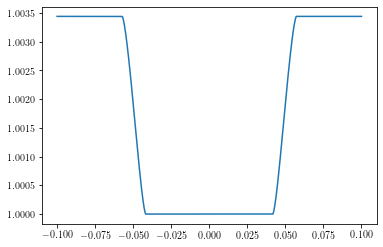

In [3]:
p.plot(time, flux);

In [4]:
# Use prettier plot defaults 
plot_utils.plot_setup()

In [5]:
# Get wavelength-dependent healpix map
lamhr, spaxels = gen_lightcurves.prep_spectral_hotspot_map(Nside=16)

/Users/Jake/anaconda2/envs/py3/lib/python3.6/site-packages/healpy/projaxes.py:1031: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


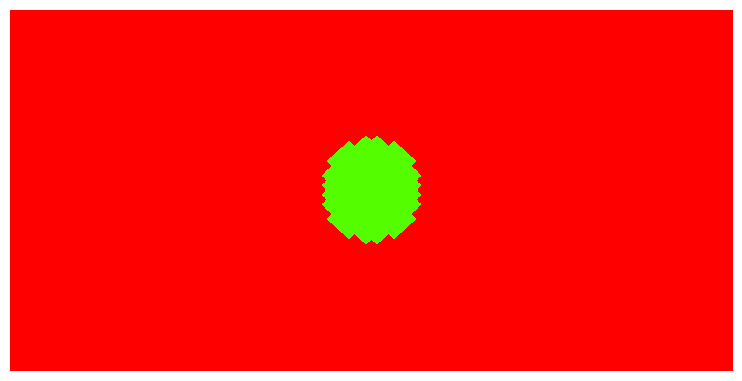

In [6]:
#origData = np.load("data/maps/mystery_map{}.npz".format(testNum))
lammin1 = 2.41; lammax1 = 3.98; dlam1 = 0.18
#spaxels = origData["spaxels"]
#lam = origData["wl"]
lamlo, dlamlo = gen_lightcurves.construct_lam(lammin1, lammax1, dlam=dlam1)
Nlamlo = len(lamlo)

# Set HealPy pixel numbers
Npix = spaxels.shape[0]

# Define empty 2d array for spaxels
spec2d = np.zeros((Npix, Nlamlo))

# Loop over pixels filling with spectra
for i in range(Npix):
    # Degrade the spectra to lower resolution
    spec2d[i,:] = gen_lightcurves.downbin_spec(spaxels[i, :], lamhr, lamlo, dlam = dlamlo)


waveInd = 0
x = hp.cartview(spec2d[:,waveInd], title="", cbar=False, cmap=p.cm.prism, lonra=[-180,180], latra=[-90,90], notext=False, 
            return_projected_map = True)



In [7]:
from eigensource.plot_utils import create_linear_colormap

In [8]:
# Generate the multi-wavelength eclipse lightcurves using starry
time, lam, dlam, lcurves = gen_lightcurves.create_lightcurves_with_starry(lamhr, spaxels, save_output=False, save_tag="hotspot",
                                                                          plot_lightcurves = True, 
                                                                          plot_diagnostic = True, 
                                                                          plot_points_on_map_spec=True)

Pre-computing some matrices... Done.
Invalid keyword `a` in call to `Secondary()`. Ignoring.
Compiling `intensity`... Done.
Pre-computing some matrices... Done.
Compiling `X`... Done.
/Users/Jake/anaconda2/envs/py3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


ValueError: Input dimension mis-match. (input[0].shape[1] = 10, input[1].shape[1] = 4)
Apply node that caused the error: Elemwise{Mul}[(0, 1)](InplaceDimShuffle{x,0}.0, AdvancedIncSubtensor1{inplace,set}.0)
Toposort index: 120
Inputs types: [TensorType(float64, row), TensorType(float64, matrix)]
Inputs shapes: [(1, 10), (10000, 4)]
Inputs strides: [(80, 8), (32, 8)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[AdvancedSubtensor1(Elemwise{Mul}[(0, 1)].0, AdvancedBooleanSubtensor.0), Elemwise{Add}[(0, 0)](Elemwise{Mul}[(0, 1)].0, AdvancedIncSubtensor1{inplace,set}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [21]:
cm = create_linear_colormap(c1 = "deepskyblue", c2 = "orange")

In [22]:
extent=(np.max(time)-np.min(time))/2.21857567+180./360.
data_extent = (-180, 180, -90, 90)
full_extent = np.array([-extent/2.*360.,extent/2.*360.,-90.,90.])

In [23]:
full_extent

array([-106.22662706,  106.22662706,  -90.        ,   90.        ])

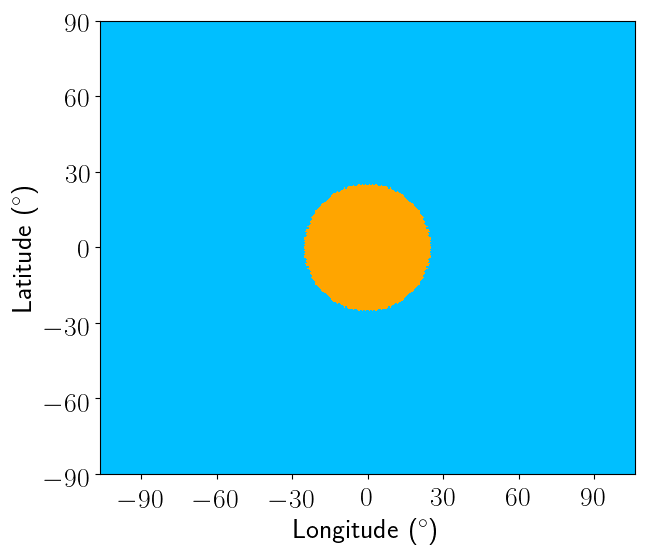

In [24]:
fig, ax = p.subplots(figsize = (8,6))

ax.imshow(x, origin="lower", extent = data_extent, cmap=cm, aspect="equal")
ax.set_ylabel("Latitude ($^{\circ}$)")
ax.set_xlabel("Longitude ($^{\circ}$)")
#ax.set_xticks([-180, -90, 0, 90, 180])
ax.set_xlim(full_extent[0], full_extent[1])
ax.set_ylim(full_extent[2], full_extent[3])
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90])
ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])

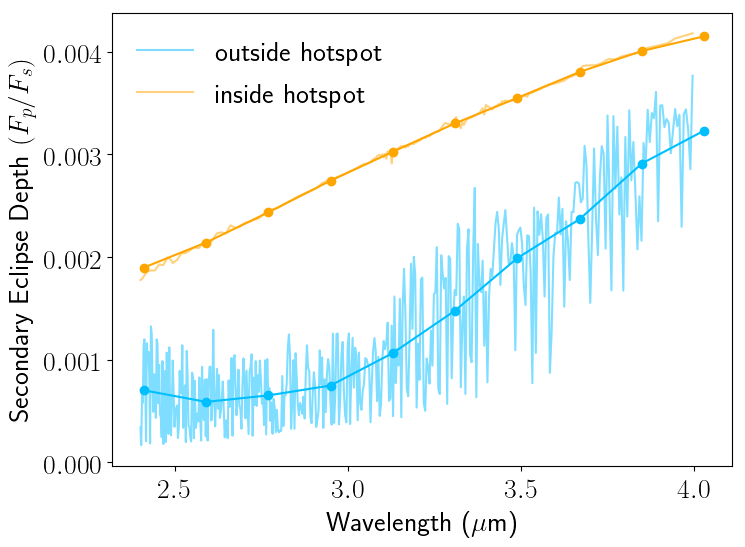

In [35]:
fig, ax = p.subplots(figsize = (8,6))
ax.set_xlabel("Wavelength ($\mu$m)")
ax.set_ylabel("Secondary Eclipse Depth $(F_p / F_s)$")

# Find the index of the spectrum inside and outside the hotspot (cheap hack for this map case)
imin = np.argmin(np.sum(spaxels, axis=1))
imax = np.argmax(np.sum(spaxels, axis=1))

ax.plot(lamhr, spaxels[imin,:], color = "deepskyblue", alpha = 0.5, label="outside hotspot")
ax.plot(lamlo, spec2d[imin,:], "-o", color = "deepskyblue")

ax.plot(lamhr, spaxels[imax,:], color = "orange", alpha = 0.5, label="inside hotspot")
ax.plot(lamlo, spec2d[imax,:], "-o", color = "orange")

ax.legend(framealpha = 0.0)

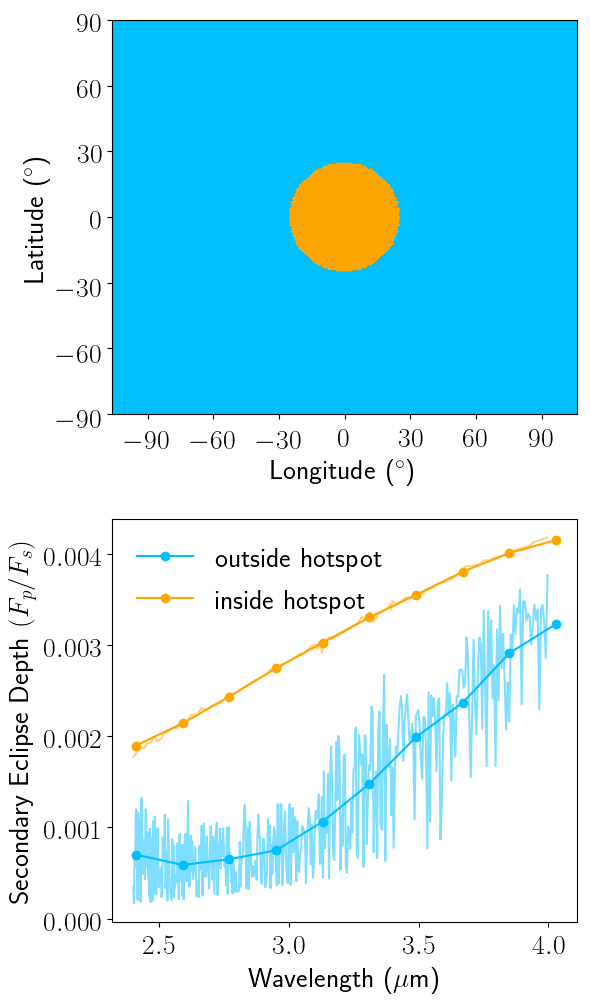

In [36]:
fig, ax = p.subplots(2,1, figsize = (6, 12), gridspec_kw={"hspace" : 0.25})

ax[0].imshow(x, origin="lower", extent = data_extent, cmap=cm, aspect="equal")
ax[0].set_ylabel("Latitude ($^{\circ}$)")
ax[0].set_xlabel("Longitude ($^{\circ}$)")
ax[0].set_xlim(full_extent[0], full_extent[1])
ax[0].set_ylim(full_extent[2], full_extent[3])
ax[0].set_yticks([-90, -60, -30, 0, 30, 60, 90])
ax[0].set_xticks([-90, -60, -30, 0, 30, 60, 90])

ax[1].set_xlabel("Wavelength ($\mu$m)")
ax[1].set_ylabel("Secondary Eclipse Depth $(F_p / F_s)$")
ax[1].plot(lamhr, spaxels[imin,:], color = "deepskyblue", alpha = 0.5)
ax[1].plot(lamlo, spec2d[imin,:], "-o", color = "deepskyblue", label="outside hotspot")
ax[1].plot(lamhr, spaxels[imax,:], color = "orange", alpha = 0.5)
ax[1].plot(lamlo, spec2d[imax,:], "-o", color = "orange", label="inside hotspot")
ax[1].legend(framealpha = 0.0)

#fig.tight_layout()
fig.savefig("plots/paper_figures/hotspot_inputs64.png", bbox_inches = "tight")